In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("../..")
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from multiscale_sde.util import softplus_inverse

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

manual_seed(0)
plt.style.use('seaborn-poster')
import seaborn as sns 

/tmp/ipykernel_124853/2298321416.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
torch.rand(500, 5).shape

torch.Size([500, 5])

In [39]:
# generate data 
ts = np.linspace(0., 2., 200)
# ts = np.concatenate(
#     [
#         np.random.uniform(low=0.1, high=0.5, size=20),
#         np.random.uniform(low=1.5, high=1.9, size=20)
#     ],
#     axis=0
# )
# ts = np.sort(ts)
# ts = np.array([0.] + list(ts) + [2.0])
ts = torch.Tensor(ts).to(device)

In [40]:
method = "euler"
dt = 1e-3
adaptive = False
rtol = 1e-3
atol = 1e-3
adjoint = False
kl_anneal_iters = 100
dpi = 300
batch_size=512
sdeint_fn = torchsde.sdeint


In [44]:
class AgeHeartSDE(torchsde.SDEIto):

    def __init__(self, period=0.2, device="cpu"):
        super().__init__(noise_type="diagonal")
        self.device = device
        # let's do t\in [0, 2]
        self.period = period
        self.y0_mean = torch.Tensor([0, 0]).to(device) 
        self.y0_std = torch.Tensor([0.1, 0.1]).to(device) 
        

    def f(self, t, y):  # drift
        y_1 = y[:,:1]
        y_2 = y[:,1:]
        drift = torch.ones(y.size(), device=self.device)
        # drift_1 = torch.ones(y_1.size(), device=self.device)
        # drift_2 = 5*y_1*torch.cos(2*np.pi*y_1/self.period)
        # drift = torch.cat([drift_1, drift_2], axis=1)
        return drift
    
    
    def g(self, t, y):  # Diffusion.
        diffusion = torch.ones(y.size(), device=self.device)
        diffusion[..., 0] = 0.1
        diffusion[..., 1] = 1
        return diffusion

        # return torch.ones(y.size(), device=self.device)*0.01

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.y0_std) if eps is None else eps
        y0 = self.y0_mean + eps * self.y0_std
        ys = sdeint_fn(
            sde=self,
            y0=y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f', 'diffusion': 'g'}
        )
        return ys

In [45]:
dataSDE = AgeHeartSDE(period=0.2, device=device)
# sample some points from this multiscale system
y = dataSDE.forward(ts[:,None], batch_size=5)

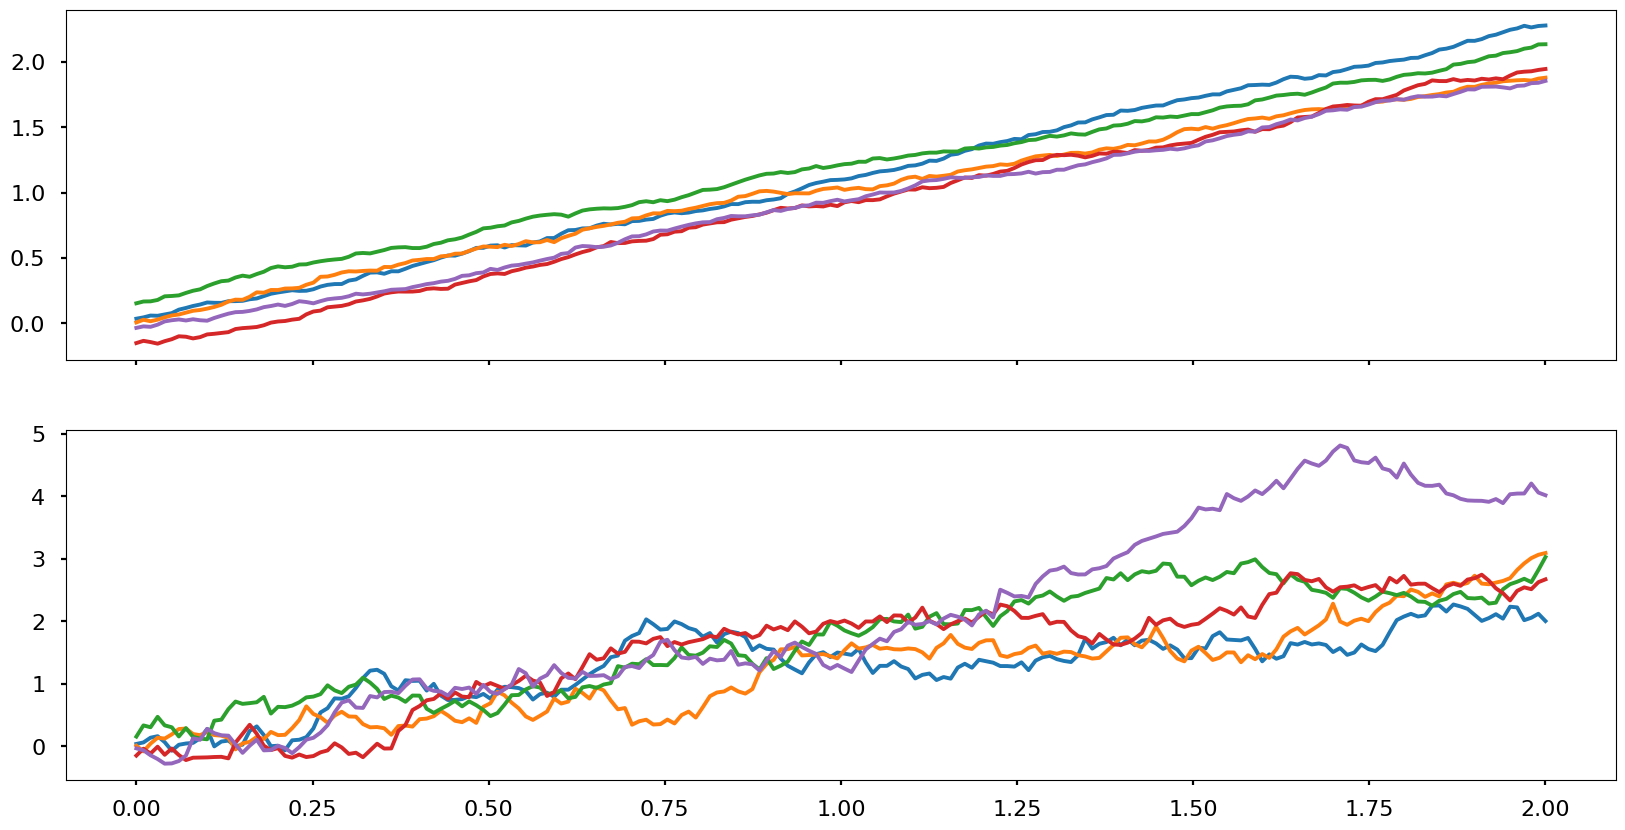

In [46]:
y_plot = y.cpu().detach().numpy()
ts_plot = ts.detach().cpu().numpy()
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_plot[:,:,0])
ax2.plot(ts_plot, y_plot[:,:,1])

## 

In [52]:
np.savez("../../data/synthetic/linear_varyingsmoothness_full.npz", y=y.numpy())

In [51]:
y.shape

torch.Size([200, 5, 2])

In [13]:
## select training data
ts_train = ts[:, None]
y_train = y[:,0,:]


In [14]:
y_train.size(), ts_train.size()

(torch.Size([42, 2]), torch.Size([42, 1]))

## Latent SDE

In [35]:
# pick SDEInt
sdeint_fn = torchsde.sdeint

# pick model hyperparameters
method = "euler"
dt = 1e-2
adaptive = False 
rtol = 1e-3
atol = 1e-3

class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out
        
class LatentSDE(torchsde.SDEIto):

    def __init__(self, num_latent: int = 1, device: str = "cpu"):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        self.num_latent = num_latent
        self.device = device

        # encode the data and output initial conditions for the 
        # posterior SDEs
        self.encoder = Encoder(1, 32, (num_latent+1)*2)

        # Approximate posterior drifts
        self.net1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(1 + num_latent, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_latent)
        )

        # # Prior drifts
        self.prior_net1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self.prior_net2 = nn.Sequential(
            nn.Linear(1 + num_latent, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_latent)
        )

        self.decoder = nn.Sequential(
            nn.Linear(num_latent, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Initialization trick from Glow.
        self.net1[-1].weight.data.fill_(0.)
        self.net1[-1].bias.data.fill_(0.)
        self.net2[-1].weight.data.fill_(0.)
        self.net2[-1].bias.data.fill_(0.)
        # self.prior_net1[-1].weight.data.fill_(0.)
        # self.prior_net1[-1].bias.data.fill_(0.)
        # self.prior_net2[-1].weight.data.fill_(0.)
        # self.prior_net2[-1].bias.data.fill_(0.)

        # set prior and posterior initial conditions
        # self.register_buffer("py0_mean", torch.zeros((2)))
        # self.register_buffer("py0_std", torch.ones((2)))
        self.py0_mean = nn.Parameter(torch.tensor([0.] + [0.2]*num_latent), requires_grad=True)
        self.py0_std_unconstrained = nn.Parameter(torch.tensor([-3.] + [-3.]*num_latent), requires_grad=True)
        # self.qy0_mean = nn.Parameter(torch.tensor([0.] + [.2]*num_latent), requires_grad=True)
        # self.qy0_std_unconstrained = nn.Parameter(torch.tensor([-3.] + [-3.]*num_latent), requires_grad=True)
        # self.register_buffer("py0_mean", torch.tensor([0., 0.]))
        # self.register_buffer("py0_std", torch.tensor([0.1, 0.1]))
        # self.register_buffer("diffusion", torch.tensor([0.5]))
        # self.diffusion_unconstrained = nn.Parameter(torch.tensor([0.5]), requires_grad=False)
    # @property
    # def qy0_std(self):
    #     # return self.qy0_std_unconstrained
    #     return nn.functional.softplus(self.qy0_std_unconstrained)
    @property
    def py0_std(self):
        # return self.py0_std_unconstrained
        return nn.functional.softplus(self.py0_std_unconstrained)
    # @property
    # def diffusion(self):
    #     # return self.diffusion_unconstrained
    #     return nn.functional.softplus(self.diffusion_unconstrained)

    def f_1(self, t, y):
        return self.net1(y)
    def f_2(self, t, y):
        return self.net2(y)

    def f(self, t, y):  # Approximate posterior drift.

        # neural networks with fourier time features
        # t = torch.full_like(y[:,:1], fill_value=t.item())
        # drift1 = self.net1(torch.cat((torch.sin(t), torch.cos(t), y[:, :1]), axis=1))
        # drift2 = self.net2(torch.cat((torch.sin(t), torch.cos(t), y), axis=1))
        
        # neural network
        drift1 = self.f_1(t, y[:,:1])
        drift2 = self.f_2(t, y)

        # # ground truth
        # # drift1 = torch.ones(y[:,:1].size(), device=self.device)
        # # drift2 = 20*y[:,:1]*torch.cos(2*np.pi * y[:,:1] / 0.2) + y[:,1:2]
        drift = torch.cat([drift1, drift2], axis=1)
        return drift
        # y_1 = y[:,:1]
        # y_2 = y[:,1:]
        # drift_1 = torch.ones(y_1.size(), device=self.device)
        # drift_2 = 20*y_1*torch.cos(2*np.pi * y_1 / 0.2) + y_2
        # drift = torch.cat([drift_1, drift_2], axis=1)
        # return drift
    def f_1_prior(self, t, y):
        return self.prior_net1(y)
        # return -y/2
    def f_2_prior(self, t, y):
        return self.prior_net2(y)
        # return -y/2
    def f_prior(self, t, y):  # Prior drift.
        # drift1 = self.f_1_prior(t, y[:,:1])
        # drift2 = self.f_2_prior(t, y)
        # drift = torch.cat([drift1, drift2], axis=1)
        # return drift
        # return -y/4
        y_1 = y[:,:1]
        # y_2 = y[:,1:]
        drift1 = torch.ones(y_1.size(), device=self.device)
        # drift1 = self.f_1_prior(t, y_1)
        drift2 = self.f_2_prior(t, y)
        # drift_2 = -y/2
        drift = torch.cat([drift1, drift2], axis=1)
        return drift

    def g(self, t, y):  # Shared diffusion.
        """
        """
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return torch.ones(y.size(), device=self.device)*0.1
        # return torch.ones(y.size(), device=self.device)*math.sqrt(2)
    
    ## augmented drift and diffusions
    def f_aug_1(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:,:-1]
        f, g, f_prior = self.f_1(t, y), self.g(t, y), self.f_1_prior(t, y)
        u = _stable_division(f - f_prior, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:,:-1]
        f, g, f_prior = self.f(t, y), self.g(t, y), self.f_prior(t, y)
        u = _stable_division(f - f_prior, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:,:-1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y[:,:1])
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, ys, eps=None):
        q_out = self.encoder(torch.flip(ys, dims=(0,)))[-1]
        qy0_mean = q_out[:self.num_latent+1]
        qy0_std = nn.functional.softplus(q_out[self.num_latent+1:])
        
        eps = torch.randn(batch_size, (1+self.num_latent)).to(qy0_std) if eps is None else eps

        # y0 = self.qy0_mean + eps * self.qy0_std
        y0 = qy0_mean + eps * qy0_std

        qy0 = distributions.Normal(loc=qy0_mean, scale=qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum() # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, :(1+self.num_latent)], aug_ys[-1, :, -1]
        logqp = (logqp0+logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        if self.num_latent != 1:
            y_pred = self.decoder(ys[..., 1:].reshape(-1, self.num_latent))
            y_pred = y_pred.reshape(-1, batch_size, 1)
        else:
            y_pred = ys[..., 1:]
        return ys, y_pred, logqp

    # faster forward skip
    def forward_skip(self, batch_size, ys, ts_segments, ts_segments_slow, eps=None):
        q_out = self.encoder(torch.flip(ys, dims=(0,)))[-1]
        qy0_mean = q_out[:self.num_latent+1]
        qy0_std = nn.functional.softplus(q_out[self.num_latent+1:])
        
        eps = torch.randn(batch_size, 1+self.num_latent).to(qy0_std) if eps is None else eps
        y0 = qy0_mean + eps * qy0_std
        qy0 = distributions.Normal(loc=qy0_mean, scale=qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum() # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, self.num_latent).to(y0)], dim=1)
        # Procedure:
        # Step 1: solve in 1st interval. with dt=1e-2
        # from t_start-tau to t_end+tau
        # Step 2: solve in 2nd interval (skipped). Only solve for slow variables
        # with dt=1e-1
        # Step 3: Solve from t_start-2*tau so that we can get stationary samples 

        for i, ts_segment in enumerate(ts_segments):
            # solve both variables
            aug_ys = sdeint_fn(
                sde=self,
                y0=aug_y0,
                ts=ts_segment,
                method=method,
                dt=1e-2,
                adaptive=adaptive,
                rtol=rtol,
                atol=atol,
                names={'drift': 'f_aug', 'diffusion': 'g_aug'}
            )
            ys_segment, logqp_path = aug_ys[:, :, :(1+self.num_latent)], aug_ys[-1, :, -1:]
            if i == 0:
                ys = ys_segment[1:-1]
            else:
                ys = torch.concat([ys, ys_segment[1:-1]], axis=0)

            if i < len(ts_segments) - 1:
                # random initialisation of all variables
                eps = torch.randn(batch_size, self.num_latent).to(qy0_std) if eps is None else eps
                y0 = qy0_mean + eps * qy0_std
                aug_y0 = torch.cat([y0, logqp_path], dim=1)

                # solve slow variables
                # no need to reinitialise slow variables
                aug_y0_slow = torch.cat([aug_ys[-1, :, :1],aug_y0[:, -1:]], axis=1)
                aug_ys = sdeint_fn(
                    sde=self,
                    y0=aug_y0_slow,
                    ts=ts_segments_slow[i],
                    method=method,
                    dt=1e-2,
                    adaptive=adaptive,
                    rtol=rtol,
                    atol=atol,
                    names={'drift': 'f_aug_1', 'diffusion': 'g_aug'}
                )
                # after solving the slow variables, reinitialise the initial sample
                # extract the final value of the slow variable
                # extract the final value of the sum of slow variable KLs
                aug_y0[:,0] = aug_ys[-1, :,0]
                aug_y0[:,-1] = aug_ys[-1, :,-1]
        ys = ys[:, :, :(1+self.num_latent)]
        logqp = (logqp0+logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        if self.num_latent != 1:
            y_pred = self.decoder(ys[..., 1:].reshape(-1, self.num_latent))
            y_pred = y_pred.reshape(-1, batch_size, 1)
        else:
            y_pred = ys[..., 1:]
        return ys, y_pred, logqp
    def sample_p(self, ts, batch_size, eps=None, bm=None):
        print(self.py0_mean.shape, self.py0_std.shape)
        eps = torch.randn(batch_size, self.num_latent+1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={'drift': 'f_prior'})
        if self.num_latent != 1:
            y_pred = self.decoder(yt[..., 1:].reshape(-1, self.num_latent))
            y_pred = y_pred.reshape(-1, batch_size, 1)
        else:
            y_pred = yt[..., 1:]
        return yt, y_pred

    def sample_q(self, ts, batch_size, ys, eps=None, bm=None):
        q_out = self.encoder(torch.flip(ys, dims=(0,)))[-1]
        qy0_mean = q_out[:self.num_latent+1]
        qy0_std = nn.functional.softplus(q_out[self.num_latent+1:])
        
        eps = torch.randn(batch_size, self.num_latent+1).to(qy0_mean) if eps is None else eps
        y0 = qy0_mean + eps * qy0_std
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={"drift" : "f"})
        if self.num_latent != 1:
            y_pred = self.decoder(yt[..., 1:].reshape(-1, self.num_latent))
            y_pred = y_pred.reshape(-1, batch_size, 1)
        else:
            y_pred = yt[..., 1:]
        return yt, y_pred

In [18]:
# mixing time
mixing_time = 0.2
# when to begin solving
t_starts = torch.Tensor([0., 1.5075])
# when to stop solving
t_ends = torch.Tensor([0.4915, 2.])

## suppose we start from y0 (data driven)
ts_segments = []
ts_segments_slow = []
for i in range(t_starts.size()[0]):
    ts_segment = ts_train[(ts_train >= t_starts[i]) & (ts_train <= t_ends[i])]     
    # start solving earlier so that we can mix fast
    ts_segment = torch.cat([ts_segment[:1] -2*mixing_time, ts_segment])
    ts_segment = torch.cat([ts_segment, ts_segment[-1:] + mixing_time])
    ts_segments.append(ts_segment)
ts_segments_slow = [torch.Tensor([ts_segments[i][-1], ts_segments[i+1][0]]).to(device)  for i in range(len(ts_segments)-1)]

In [23]:
model.encoder

Encoder(
  (gru): GRU(1, 32)
  (lin): Linear(in_features=32, out_features=6, bias=True)
)

In [36]:
model = LatentSDE(num_latent=2, device=device).to(device)
# test forward
y_forward,y_pred, kl = model.forward_skip(batch_size=10, ts_segments=ts_segments, ts_segments_slow=ts_segments_slow, ys=y_train[:, 1:])
print(y_forward.shape, y_pred.shape, kl)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x4 and 3x32)

In [51]:
model = LatentSDE(num_latent=2, device=device).to(device)
# test forward
y_forward, y_pred, kl = model.forward(ts_train, batch_size=10, ys=y_train[:,1:])
print(y_forward.shape, y_pred.shape, kl)

torch.Size([42, 10, 3]) torch.Size([42, 10, 1]) tensor(354.7161, grad_fn=<MeanBackward1>)


In [122]:
# mixing time
mixing_time = 0.2
# when to begin solving
t_starts = torch.Tensor([0., 1.5075])
# when to stop solving
t_ends = torch.Tensor([0.4915, 2.])

## suppose we start from y0 (data driven)
ts_segments = []
ts_segments_slow = []
for i in range(t_starts.size()[0]):
    ts_segment = ts_train[(ts_train >= t_starts[i]) & (ts_train <= t_ends[i])]     
    # start solving earlier so that we can mix fast
    ts_segment = torch.cat([ts_segment[:1] -2*mixing_time, ts_segment])
    ts_segment = torch.cat([ts_segment, ts_segment[-1:] + mixing_time])
    ts_segments.append(ts_segment)
ts_segments_slow = [torch.Tensor([ts_segments[i][-1], ts_segments[i+1][0]]).to(device)  for i in range(len(ts_segments)-1)]

In [123]:
model = LatentSDE(device=device).to(device)
y_forward, kl = model.forward_skip(batch_size=10, ts_segments=ts_segments, ts_segments_slow=ts_segments_slow)

tensor([-0.4000,  0.0000,  0.1081,  0.1284,  0.1349,  0.2534,  0.2695,  0.2750,
         0.2846,  0.3116,  0.3272,  0.3584,  0.4113,  0.4122,  0.4167,  0.4197,
         0.4330,  0.4480,  0.4567,  0.4702,  0.4855,  0.4914,  0.6914],
       device='cuda:0') torch.Size([23])
tensor([1.1075, 1.5075, 1.5241, 1.5473, 1.5573, 1.6058, 1.6438, 1.6659, 1.6748,
        1.6825, 1.7087, 1.7274, 1.7448, 1.7468, 1.7471, 1.7560, 1.7727, 1.7791,
        1.8097, 1.8775, 1.8779, 2.0000, 2.2000], device='cuda:0') torch.Size([23])


In [124]:
y_forward.shape, kl

(torch.Size([42, 10, 2]),
 tensor([1.0524], device='cuda:0', grad_fn=<MeanBackward1>))

In [125]:
model = LatentSDE(device=device).to(device)
# test forward
y_forward, kl = model.forward(ts_train, batch_size=10)
print(y_forward.shape, kl)

torch.Size([42, 10, 2]) tensor(0.8516, device='cuda:0', grad_fn=<MeanBackward1>)


In [126]:
# test sample_p
print(model.f_prior(ts_train, y_train).shape, model.g(ts_train, y_train).shape)
print(model.sample_p(ts_train, batch_size=5).shape)

torch.Size([42, 2]) torch.Size([42, 2])
torch.Size([42, 5, 2])


In [127]:
# test sample_q
print(model.f(ts_train, y_train).shape, model.g(ts_train, y_train).shape)
posterior_samples = model.sample_q(ts_train, batch_size=128)
print(posterior_samples.shape)

torch.Size([42, 2]) torch.Size([42, 2])
torch.Size([42, 128, 2])


Text(0.5, 0, 'Time $t$')

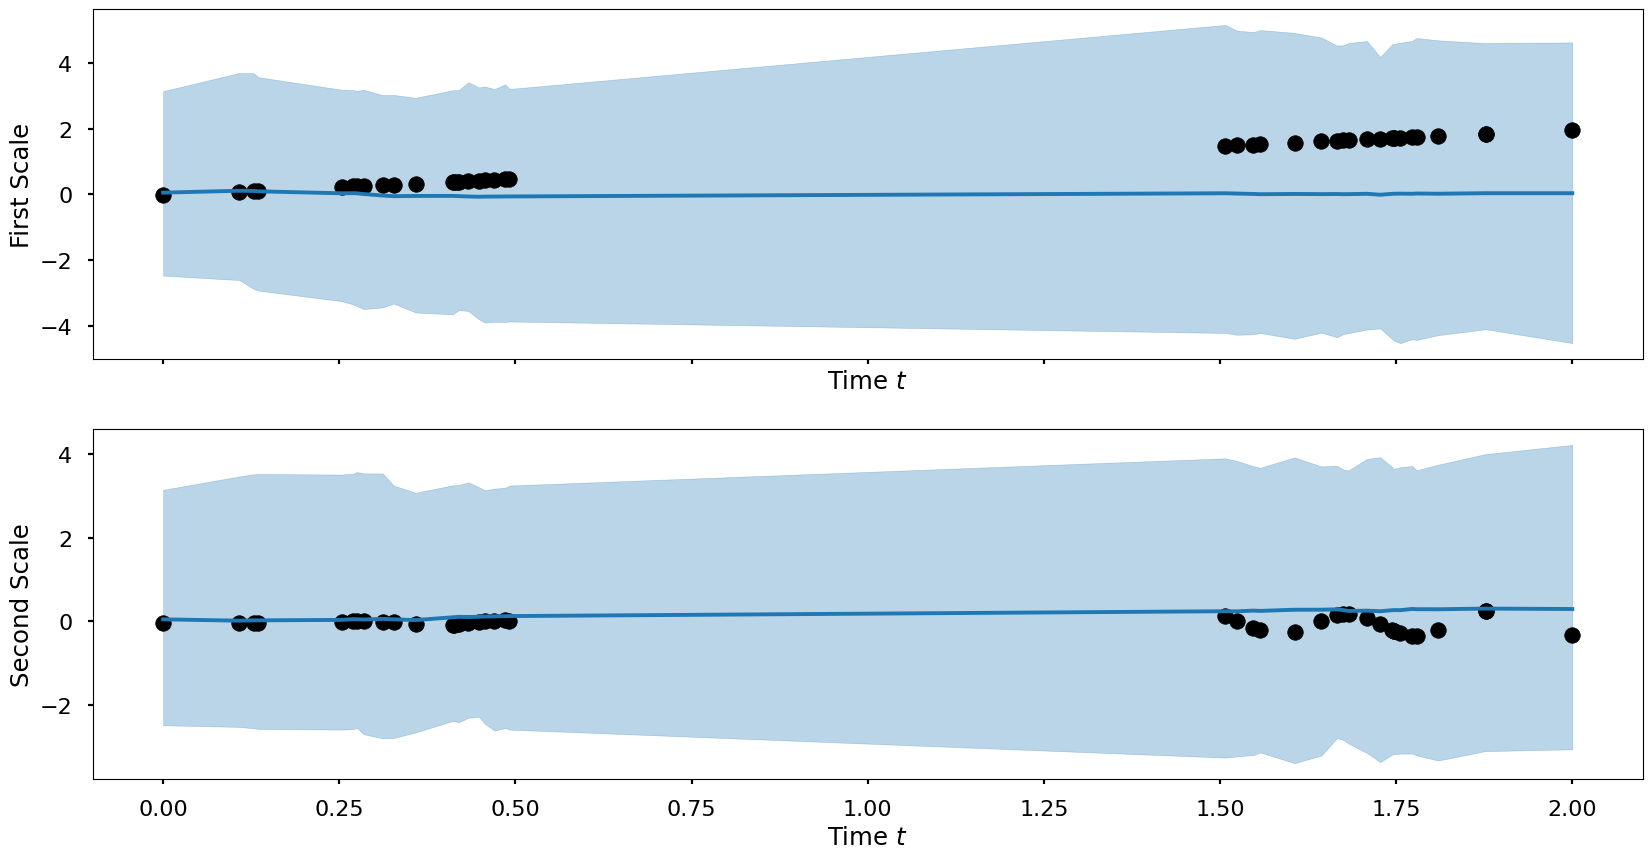

In [128]:
y_pred_plot = posterior_samples.cpu().detach().numpy()
y_pred = posterior_samples.mean(1).cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_pred[:,0], color="C0")
ax2.plot(ts_plot, y_pred[:,1], color="C0")

# plot the credible interval
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1)
y_pred_plot[:,:,1] = np.sort(y_pred_plot[:,:,1], axis=1)
percentile = 0.95
idx = int((1 - percentile) / 2. * y_pred_plot.shape[1])
y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,0], y_pred_plot[:, -idx,0]
ax1.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,1], y_pred_plot[:, -idx,1]
ax2.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

ax1.scatter(ts_plot, y_plot[:,0,0], color="black")
ax2.scatter(ts_plot, y_plot[:,0,1], color="black")

ax1.set_ylabel("First Scale")
ax2.set_ylabel("Second Scale")

ax1.set_xlabel("Time $t$")
ax2.set_xlabel("Time $t$")

In [51]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=100)

In [112]:
for global_step in tqdm.tqdm(range(300)):
        optimizer.zero_grad()
        zs, kl = model(ts=ts_train, batch_size=128)
        zs = zs.squeeze()
        # zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.
        likelihood_constructor = distributions.Normal
        likelihood = likelihood_constructor(loc=zs, scale=0.001)
        logpy = likelihood.log_prob(y_train[:,None,:]).sum(dim=[0,-1]).mean(dim=0)
        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

  0%|          | 1/300 [00:15<1:15:13, 15.09s/it]


KeyboardInterrupt: 

## Check predictions

In [98]:
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1).shape
y_pred_plot[:,:,1] = np.sort(y_pred_plot[:,:,1], axis=1).shape

(100, 32)

In [106]:
y_pred_plot_bottom.shape

(100, 32)

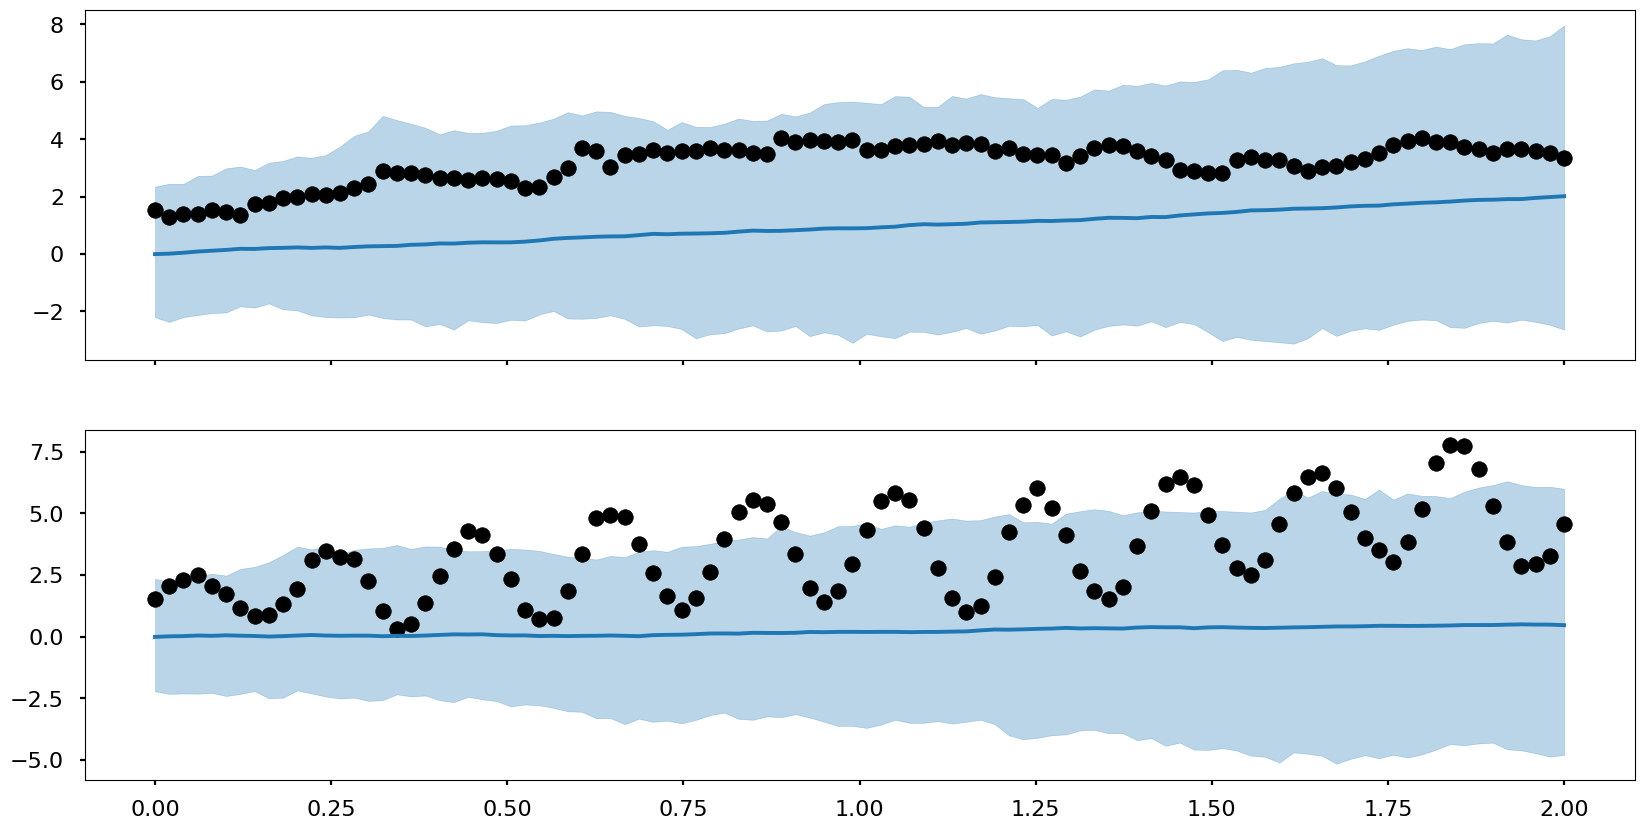

In [115]:
y_pred_plot = zs.cpu().detach().numpy()
y_pred = zs.mean(1).cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_pred[:,0], color="C0")
ax2.plot(ts_plot, y_pred[:,1], color="C0")

# plot the credible interval
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1)
y_pred_plot[:,:,1] = np.sort(y_pred_plot[:,:,1], axis=1)
percentile = 0.95
idx = int((1 - percentile) / 2. * y_pred_plot.shape[1])
y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,0], y_pred_plot[:, -idx,0]
ax1.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,1], y_pred_plot[:, -idx,1]
ax2.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

ax1.scatter(ts_plot, y_plot[:,0,0], color="black")
ax2.scatter(ts_plot, y_plot[:,0,1], color="black")
plt.savefig("data.pdf")